In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
import pandas as pd
from keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.stats import pearsonr

print(tf.__version__)
np.random.seed(422)

from sklearn.model_selection import train_test_split
from scipy import stats
from subprocess import run, check_output
import os
import random
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

2.7.0


In [40]:
def heteroscedastic_loss(true, pred):
    """ Heteroskedastic loss function."""
    params = pred.shape[1]//2
    point = pred[:, :params]
    var = pred[:, params:]
    precision = 1 / var
    return keras.backend.sum(precision * (true - point) ** 2. + keras.backend.log(var), -1)

In [41]:
def create_model(n_params, channels, filters, batchnorm = False, training = True):
    
    inp = keras.Input(shape=(None, channels))
    x = tf.keras.layers.Conv1D(filters[0], kernel_size=1, strides=1, activation='relu')(inp)  
    
    skipFunc_1 = tf.keras.layers.Conv1D(filters[0], kernel_size=1)(x)
    skipFunc_1 = tf.keras.layers.BatchNormalization(axis=2, epsilon=bnEps,momentum=bnMom)(skipFunc_1)
  
    x = tf.keras.layers.Conv1D(filters[0] , kernel_size=1 , activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters[0], kernel_size = 3, strides = 1 , use_bias=False , padding = "same")(x)
    x = tf.keras.layers.add([x, skipFunc_1])
    x = tf.keras.layers.Activation("relu")(x)
    
    skipFunc_2 = tf.keras.layers.Conv1D(filters[0], kernel_size=1)(x)
    skipFunc_2 = tf.keras.layers.BatchNormalization(axis=2, epsilon=bnEps,momentum=bnMom)(skipFunc_2)
    
    x = tf.keras.layers.Conv1D(filters[0] , kernel_size=1 , activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters[0], kernel_size = 3, strides = 1 , use_bias=False,padding = "same")(x)
    x = tf.keras.layers.add([x, skipFunc_2])
    x = tf.keras.layers.Activation("relu")(x)
   
    skipFunc_3 = tf.keras.layers.Conv1D(filters[1], kernel_size=1)(x)
    skipFunc_3 = tf.keras.layers.BatchNormalization(axis=2, epsilon=bnEps,momentum=bnMom)(skipFunc_3)
    
    x = tf.keras.layers.Conv1D(filters[1] , kernel_size=1, activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters[1], kernel_size = 3, strides = 1 , use_bias=False,padding = "same")(x)
    x = tf.keras.layers.add([x, skipFunc_3])
    x = tf.keras.layers.Activation("relu")(x)

    skipFunc_4 = tf.keras.layers.Conv1D(filters[1], kernel_size=1)(x)
    skipFunc_4 = tf.keras.layers.BatchNormalization(axis=2, epsilon=bnEps,momentum=bnMom)(skipFunc_4)
    
    x = tf.keras.layers.Conv1D(filters[1] , kernel_size=1 , activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters[1], kernel_size = 3, strides = 1 , use_bias=False,padding = "same")(x)
    x = tf.keras.layers.add([x, skipFunc_4])
    x = tf.keras.layers.Activation("relu")(x)
     
    x = keras.layers.GlobalAveragePooling1D()(x)
    
    dens1 = keras.layers.Dense(250, activation='relu')(x)
    dens2 = keras.layers.Dense(100, activation='relu')(dens1)
    dens3 = keras.layers.Dense(50, activation='relu')(dens2)

    mean = keras.layers.Dense(n_params)(dens3)
    var = keras.layers.Dense(n_params, activation='softplus')(x)
    out = keras.layers.Concatenate()([mean, var])
    model = keras.Model(inp, out)
    return model

In [43]:
def plot_analytic_vs_est(true, pred, names ,log=True, plot_abline=True,show=True,filename='figure.png',path=None):
    """Create a 3x2 plot as in paper."""
    
    def abline(slope, intercept, ax):
        x = np.array(ax.get_xlim())
        y = intercept + slope * x
        return x, y 
    
    font = {'fontname':'Arial', 'fontsize': 16}
    textfont = {'fontname':'Arial', 'fontsize': 11}
    axisfont = {'fontname':'Arial', 'fontsize': 12}
    

    f, axarr = plt.subplots(2, 3, figsize=(10, 12))
    
    print(axarr.flat)
    for i, ax in enumerate(axarr.flat):
        
       
        if i == (pred.shape[1]//2):
            print(i)
            break

        ax.plot(true[:,i], pred[:,i],marker='o', linewidth=0,alpha=0.1,color='red')

        cor = np.round(np.corrcoef(true[:,i],pred[:,i])[0,1],2)
        r_squared = np.round(1 -(np.var(true[:,i] - pred[:,i])/np.var(true[:,i])),2)
       
        ax.text(0.2,0.9,'r: ' + str(cor),ha='center', va='center', transform=ax.transAxes,**textfont)
        ax.text(0.2,0.8,'R2: ' + str(r_squared),ha='center', va='center', transform=ax.transAxes,**textfont)
        
        if plot_abline:
            ax.plot(*abline(1, 0, ax),color='black')
        else:
            ax.plot(*best_line_fit(true[:,i], pred[:,i]))
        if i == 0:
            ax.set_xlabel('True',**axisfont)
            ax.set_ylabel('Estimated',**axisfont)
            
        ax.set_title(names[i],**font)
        
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        
    plt.savefig(filename) 
    if show:
        plt.show()
        
    return None

## Defining the structure of the network

In [44]:
paramnames = ['a', 'v', 'zr','t0','T_inf']

# how deep should the model be:
filters = [64,128,128,512]

# number of channels:
nchannels = 1

# optimizer:
optimizer = 'RMSprop'


#
bnEps = 2e-5
bnMom = 0.9
reg = 0.0001

# Batch size:
batchsize = 128

checkpoint_path = "trained_CB_model_resnet_clean.hdf5"

In [45]:
keras.backend.clear_session()
Resnet = create_model(n_params=len(paramnames),channels=nchannels,filters=filters)
Resnet.compile(optimizer=optimizer, loss=heteroscedastic_loss
)
earlystopper = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)
checkpointer = keras.callbacks.ModelCheckpoint(checkpoint_path,save_best_only=True,verbose=1)
Resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, None, 64)     128         ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, None, 64)     4160        ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, None, 64)     4160        ['conv1d[0][0]']                 
                                                                                              

## Loading training data

In [46]:
n_file = 200
X = np.empty((n_file*200, 240))
y = np.empty((n_file*200, 5))

for i in range(n_file):
    x_temp = np.load('Data_Generation/CB_DataSet/X_train' + str(i) + '.npy')
    X[i*200:(i+1)*200, :] = x_temp
    

for i in range(n_file):
    y_temp = np.load('Data_Generation/CB_DataSet/y_train' + str(i) + '.npy')
    y[i*200:(i+1)*200, :] = y_temp
    
    


In [47]:
X.shape , y.shape

((40000, 240), (40000, 5))

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.005, random_state=0)

In [49]:
def get_shape(data):
    print(data.shape)

for d in [X_train, X_test, y_train, y_test]:
    get_shape(d)

(39800, 240)
(200, 240)
(39800, 5)
(200, 5)


## Apply PCA 

In [205]:
pca_1 = PCA(n_components=0.95)
pca_2 = PCA(n_components=0.8)
pca_3 = PCA(n_components=0.5)

In [206]:
X_train = pca_1.fit_transform(X_train)
X_test = pca_1.fit_transform(X_test)

In [207]:
for d in [X_train,X_test]:
    get_shape(d)

(27860, 159)
(140, 27)


## Training the network

In [50]:
history = Resnet.fit(X_train, 
                    y_train, 
                    batch_size=batchsize,
                    epochs=20,  
                    validation_split=0.1,
                    callbacks=[checkpointer])
    

Epoch 1/20
280/280 [==============================] - ETA: 0s - loss: 3.2491
Epoch 00001: val_loss improved from inf to 0.69561, saving model to trained_CB_model_resnet_clean.hdf5
280/280 [==============================] - 116s 408ms/step - loss: 3.2491 - val_loss: 0.6956
Epoch 2/20
280/280 [==============================] - ETA: 0s - loss: 0.6450
Epoch 00002: val_loss improved from 0.69561 to -0.06902, saving model to trained_CB_model_resnet_clean.hdf5
280/280 [==============================] - 114s 408ms/step - loss: 0.6450 - val_loss: -0.0690
Epoch 3/20
280/280 [==============================] - ETA: 0s - loss: 2.7248
Epoch 00003: val_loss improved from -0.06902 to -0.87987, saving model to trained_CB_model_resnet_clean.hdf5
280/280 [==============================] - 115s 410ms/step - loss: 2.7248 - val_loss: -0.8799
Epoch 4/20
280/280 [==============================] - ETA: 0s - loss: -0.6908
Epoch 00004: val_loss did not improve from -0.87987
280/280 [=============================

5


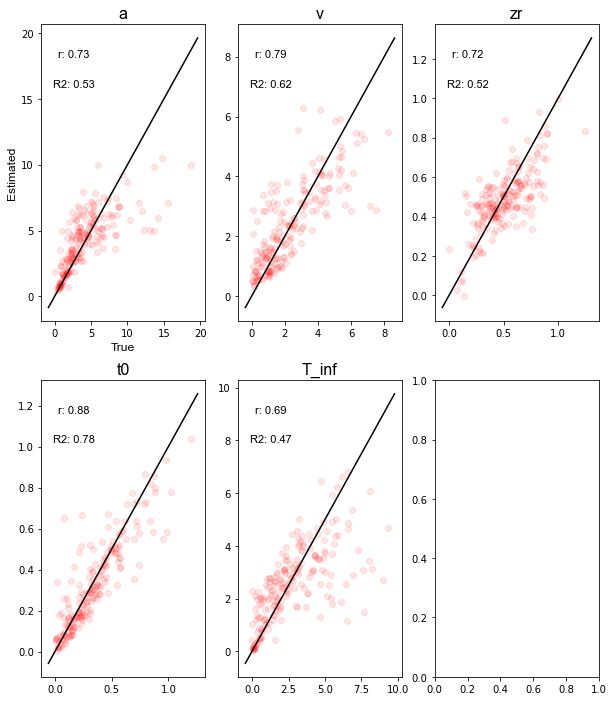

In [51]:
pred = Resnet.predict(X_test)
plot_analytic_vs_est(y_test,
                     pred,
                     log=True,
                     names=paramnames,
                     show=True,
                     filename='result/ResnetCBD.png')


In [ ]:
# plot_analytic_vs_est(y,
#                      pred,
#                      log=True,
#                      names=paramnames,
#                      show=True,
#                      filename='_plot/ResnetCBD.png')


## Fitting the Levy Flights model on data

In [ ]:
Data_dirs = ["../_GroupsData/_Trial/_Optim/",
             "../_GroupsData/_Trial/_Norm/",
             "../_GroupsData/_Trial/_Info/"]

trial_sbj_prms = []
trial_ACC_list = []
for i in range(3):
    files = os.listdir(Data_dirs[i])
    for j in range(len(files)):
        if files[j].endswith(".txt"):
            with open(Data_dirs[i] + files[j], 'r') as f:
                 
                S = np.empty((1, 240, 4))
                ACC = []
                
                f.readline()
                f.readline()
                line = f.readline()
                cor_count = 0
                line_count = 1
                for block in range(4):
                    rtl = []
                    rtu = []
                    for l in range(240):
                        s_line = line[:-1].split('\t')
                        trial = int(s_line[1])
                        acc = int(s_line[7])
                        RT = int(s_line[10])
                        if RT>0.3:
                            if acc == 1:
                                rtu.append(RT/1000)
                            else:
                                rtl.append(-RT/1000)
                        line_count += 1
                        line = f.readline()
                    S[0, :, block] = np.asarray(rtu+rtl)
                    ACC.append(len(rtu)/240)
                pred = deepInference.predict(S)
                trial_sbj_prms.append(list(pred[0][0:11]) + ACC)
                trial_ACC_list += ACC 

                

# Plotting the fitting results

### Low Information Condition

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(trial_sbj_prms[10][0:4]);
plt.plot(trial_sbj_prms[11][0:4]);
plt.plot(trial_sbj_prms[12][0:4]);
plt.plot(trial_sbj_prms[13][0:4]);
plt.plot(trial_sbj_prms[14][0:4]);
plt.plot(trial_sbj_prms[15][0:4]);
plt.plot(trial_sbj_prms[16][0:4]);
plt.plot(trial_sbj_prms[17][0:4]);
plt.plot(trial_sbj_prms[18][0:4]);
plt.plot(trial_sbj_prms[19][0:4]);
plt.plot(['1', '2', '3', '4'], trial_sbj_prms[20][0:4]);
plt.xlabel('blocks', fontsize=15);
plt.ylabel('threshold value', fontsize=15);
plt.title('Trends of threshold during the blocks in Low Information condition', fontsize=15);
plt.savefig('_plot/_norm_trial_ind_thr.png');

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(trial_sbj_prms[10][7:11]);
plt.plot(trial_sbj_prms[11][7:11]);
plt.plot(trial_sbj_prms[12][7:11]);
plt.plot(trial_sbj_prms[13][7:11]);
plt.plot(trial_sbj_prms[14][7:11]);
plt.plot(trial_sbj_prms[15][7:11]);
plt.plot(trial_sbj_prms[16][7:11]);
plt.plot(trial_sbj_prms[17][7:11]);
plt.plot(trial_sbj_prms[18][7:11]);
plt.plot(trial_sbj_prms[19][7:11]);
plt.plot(['1', '2', '3', '4'], trial_sbj_prms[20][7:11]);
plt.xlabel('blocks', fontsize=15);
plt.ylabel('alpha value', fontsize=15);
plt.title('Trends of alpha during the blocks in Low Information condition', fontsize=15);
plt.savefig('_plot/_norm_trial_ind_alpha.png');

In [ ]:
ll = []
for i in range(10,21):
    ll.append(trial_sbj_prms[i][0:4])
g1 = {'1': [ll[i][0] for i in range(len(ll))],
      '2': [ll[i][1] for i in range(len(ll))],
      '3': [ll[i][2] for i in range(len(ll))],
      '4': [ll[i][3] for i in range(len(ll))]}
df1 = pd.DataFrame(g1)
plt.figure(figsize=(10,10))
df1.boxplot(column=['1', '2', '3', '4'], grid=False);
plt.xlabel('blocks', fontsize=15);
plt.ylabel('threshold value', fontsize=15);
plt.title('Trends of threshold during the blocks in Low Information condition', fontsize=15);
plt.savefig('_plot/_norm_trial_group_thr.png');

In [ ]:
ll = []
for i in range(10, 21):
    ll.append(trial_sbj_prms[i][7:11])
g1 = {'1': [ll[i][0] for i in range(len(ll))],
      '2': [ll[i][1] for i in range(len(ll))],
      '3': [ll[i][2] for i in range(len(ll))],
      '4': [ll[i][3] for i in range(len(ll))]}
df1 = pd.DataFrame(g1)

plt.figure(figsize=(10,10))
df1.boxplot(column=['1', '2', '3', '4'], grid=False);
plt.xlabel('blocks', fontsize=15);
plt.ylabel('alpha value', fontsize=15);
plt.title('Trends of alpha during the blocks in Low Information condition', fontsize=15);
plt.savefig('_plot/_norm_trial_group_alpha.png');

In [ ]:
alpha_list = []
thr_list = []
for i in range(10, 21):
    alpha_list += list(trial_sbj_prms[i][7:11])
    thr_list += list(trial_sbj_prms[i][0:4])

plt.figure(figsize=(10,10))
sns.regplot(alpha_list , thr_list);

plt.xlabel('alpha', fontsize=15);
plt.ylabel('threshold', fontsize=15);
plt.title('Correlation of threshold and alpha in Low Information condition', fontsize=15);

cor, p_value = pearsonr(alpha_list , thr_list)
textstr = 'correlation = ' + str(cor)[0:5] + '\np-value = '+str(p_value)[0:5]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text((plt.xlim()[1] - plt.xlim()[0])*0.04 + plt.xlim()[0],
         (plt.ylim()[1] - plt.ylim()[0])*0.92 + plt.ylim()[0], textstr, fontsize=14, bbox=props)
plt.savefig('_plot/_norm_trial_thr_alpha_cor.png');

In [ ]:
alpha_list = []
acc_list = []
for i in range(10, 21):
    alpha_list += list(trial_sbj_prms[i][7:11])
    acc_list += list(trial_sbj_prms[i][11:15])

plt.figure(figsize=(10,10))
sns.regplot(alpha_list , acc_list);

plt.xlabel('alpha', fontsize=15);
plt.ylabel('ACC', fontsize=15);
plt.title('Correlation of ACC and alpha in Low Information conditions', fontsize=15);

cor, p_value = pearsonr(alpha_list , acc_list)
textstr = 'correlation = ' + str(cor)[0:5] + '\np-value = '+str(p_value)[0:5]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text((plt.xlim()[1] - plt.xlim()[0])*0.04 + plt.xlim()[0],
         (plt.ylim()[1] - plt.ylim()[0])*0.92 + plt.ylim()[0], textstr, fontsize=14, bbox=props)

plt.savefig('_plot/_norm_trial_acc_alpha_cor.png');
print("correlation is : ", cor, 'and p-value is : ', p_value)

### Medium Information Condition

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(trial_sbj_prms[21][0:4]);
plt.plot(trial_sbj_prms[22][0:4]);
plt.plot(trial_sbj_prms[23][0:4]);
plt.plot(trial_sbj_prms[24][0:4]);
plt.plot(trial_sbj_prms[25][0:4]);
plt.plot(trial_sbj_prms[26][0:4]);
plt.plot(trial_sbj_prms[27][0:4]);
plt.plot(trial_sbj_prms[28][0:4]);
plt.plot(['1', '2', '3', '4'],trial_sbj_prms[29][0:4]);
plt.xlabel('blocks', fontsize=15);
plt.ylabel('threshold value', fontsize=15);
plt.title('Trends of threshold during the blocks in Medium Information condition', fontsize=15);
plt.savefig('_plot/_info_trial_ind_thr.png');

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(trial_sbj_prms[21][7:11]);
plt.plot(trial_sbj_prms[22][7:11]);
plt.plot(trial_sbj_prms[23][7:11]);
plt.plot(trial_sbj_prms[24][7:11]);
plt.plot(trial_sbj_prms[25][7:11]);
plt.plot(trial_sbj_prms[26][7:11]);
plt.plot(trial_sbj_prms[27][7:11]);
plt.plot(trial_sbj_prms[28][7:11]);
plt.plot(['1', '2', '3', '4'], trial_sbj_prms[29][7:11]);
plt.xlabel('blocks', fontsize=15);
plt.ylabel('alpha value', fontsize=15);
plt.title('Trends of alpha during the blocks in Medium Information condition', fontsize=15);
plt.savefig('_plot/_info_trial_ind_alpha.png');

In [ ]:
ll = []
for i in range(21,30):
    ll.append(trial_sbj_prms[i][0:4])
g1 = {'1': [ll[i][0] for i in range(len(ll))],
      '2': [ll[i][1] for i in range(len(ll))],
      '3': [ll[i][2] for i in range(len(ll))],
      '4': [ll[i][3] for i in range(len(ll))]}
df1 = pd.DataFrame(g1)
plt.figure(figsize=(10,10))
df1.boxplot(column=['1', '2', '3', '4'], grid=False);
plt.xlabel('blocks', fontsize=15);
plt.ylabel('threshold value', fontsize=15);
plt.title('Trends of threshold during the blocks in Medium Information condition', fontsize=15);
plt.savefig('_plot/_info_trial_group_thr.png');

In [ ]:
ll = []
for i in range(21, 30):
    ll.append(trial_sbj_prms[i][7:11])
g1 = {'1': [ll[i][0] for i in range(len(ll))],
      '2': [ll[i][1] for i in range(len(ll))],
      '3': [ll[i][2] for i in range(len(ll))],
      '4': [ll[i][3] for i in range(len(ll))]}
df1 = pd.DataFrame(g1)
plt.figure(figsize=(10,10))
df1.boxplot(column=['1', '2', '3', '4'], grid=False);
plt.xlabel('blocks', fontsize=15);
plt.ylabel('alpha value', fontsize=15);
plt.title('Trends of alpha during the blocks in Medium Information condition', fontsize=15);
plt.savefig('_plot/_info_trial_group_alpha.png');

In [ ]:
alpha_list = []
thr_list = []
for i in range(21, 30):
    alpha_list += list(trial_sbj_prms[i][7:11])
    thr_list += list(trial_sbj_prms[i][0:4])

plt.figure(figsize=(10,10))
sns.regplot(alpha_list , thr_list);

plt.xlabel('alpha', fontsize=15);
plt.ylabel('threshold', fontsize=15);
plt.title('Correlation of threshold and alpha in Medium Information condition', fontsize=15);

cor, p_value = pearsonr(alpha_list , thr_list)
textstr = 'correlation = ' + str(cor)[0:5] + '\np-value = '+str(p_value)[0:5]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text((plt.xlim()[1] - plt.xlim()[0])*0.74 + plt.xlim()[0],
         (plt.ylim()[1] - plt.ylim()[0])*0.92 + plt.ylim()[0], textstr, fontsize=14, bbox=props)

plt.savefig('_plot/_info_trial_thr_alpha_cor.png');
print("correlation is : ", cor, 'and p-value is : ', p_value)

In [ ]:
alpha_list = []
acc_list = []
for i in range(21, 30):
    alpha_list += list(trial_sbj_prms[i][7:11])
    acc_list += list(trial_sbj_prms[i][11:15])

plt.figure(figsize=(10,10))
sns.regplot(alpha_list , acc_list);

plt.xlabel('alpha', fontsize=15);
plt.ylabel('ACC', fontsize=15);
plt.title('Correlation of ACC and alpha in Medium Information condition', fontsize=15);

cor, p_value = pearsonr(alpha_list , acc_list)
textstr = 'correlation = ' + str(cor)[0:5] + '\np-value = '+str(p_value)[0:5]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text((plt.xlim()[1] - plt.xlim()[0])*0.04 + plt.xlim()[0],
         (plt.ylim()[1] - plt.ylim()[0])*0.92 + plt.ylim()[0], textstr, fontsize=14, bbox=props);

plt.savefig('_plot/_info_trial_acc_alpha_cor.png');
print("correlation is : ", cor, 'and p-value is : ', p_value)

### High Information Condition

In [ ]:
plt.figure(figsize=(10,10))   
plt.plot(trial_sbj_prms[0][0:4]);
plt.plot(trial_sbj_prms[1][0:4]);
plt.plot(trial_sbj_prms[2][0:4]);
plt.plot(trial_sbj_prms[3][0:4]);
plt.plot(trial_sbj_prms[4][0:4]);
plt.plot(trial_sbj_prms[5][0:4]);
plt.plot(trial_sbj_prms[6][0:4]);
plt.plot(trial_sbj_prms[7][0:4]);
plt.plot(trial_sbj_prms[8][0:4]);
plt.plot(['1', '2', '3', '4'], trial_sbj_prms[9][0:4]);
plt.xlabel('blocks', fontsize=15);
plt.ylabel('threshold value', fontsize=15);
plt.title('Trends of threshold during the blocks in High Information condition', fontsize=15);
plt.savefig('_plot/_optim_trial_ind_thr.png');

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(trial_sbj_prms[0][7:11]);
plt.plot(trial_sbj_prms[1][7:11]);
plt.plot(trial_sbj_prms[2][7:11]);
plt.plot(trial_sbj_prms[3][7:11]);
plt.plot(trial_sbj_prms[4][7:11]);
plt.plot(trial_sbj_prms[5][7:11]);
plt.plot(trial_sbj_prms[6][7:11]);
plt.plot(trial_sbj_prms[7][7:11]);
plt.plot(trial_sbj_prms[8][7:11]);
plt.plot(['1', '2', '3', '4'], trial_sbj_prms[9][7:11]);
plt.xlabel('blocks', fontsize=15);
plt.ylabel('alpha value', fontsize=15);
plt.title('Trends of alpha during the blocks in High Information condition', fontsize=15);
plt.savefig('_plot/_optim_trial_ind_alpha.png');

In [ ]:
ll = []
for i in range(10):
    ll.append(trial_sbj_prms[i][0:4])
g1 = {'1': [ll[i][0] for i in range(len(ll))],
      '2': [ll[i][1] for i in range(len(ll))],
      '3': [ll[i][2] for i in range(len(ll))],
      '4': [ll[i][3] for i in range(len(ll))]}
df1 = pd.DataFrame(g1)

plt.figure(figsize=(10,10))
df1.boxplot(column=['1', '2', '3', '4'], grid=False);
plt.xlabel('blocks', fontsize=15);
plt.ylabel('threshold value', fontsize=15);
plt.title('Trends of threshold during the blocks in High Information condition', fontsize=15);
plt.savefig('_plot/_optim_trial_group_thr.png');

In [ ]:
ll = []
for i in range(10):
    ll.append(trial_sbj_prms[i][7:11])
g1 = {'1': [ll[i][0] for i in range(len(ll))],
      '2': [ll[i][1] for i in range(len(ll))],
      '3': [ll[i][2] for i in range(len(ll))],
      '4': [ll[i][3] for i in range(len(ll))]}
df1 = pd.DataFrame(g1)

plt.figure(figsize=(10,10))
df1.boxplot(column=['1', '2', '3', '4'], grid=False);
plt.xlabel('blocks', fontsize=15);
plt.ylabel('alpha value', fontsize=15);
plt.title('Trends of alpha during the blocks in High Information condition', fontsize=15);
plt.savefig('_plot/_optim_trial_group_alpha.png');

In [ ]:
alpha_list = []
thr_list = []
for i in range(10):
    alpha_list += list(trial_sbj_prms[i][7:11])
    thr_list += list(trial_sbj_prms[i][0:4])

plt.figure(figsize=(10,10))
sns.regplot(alpha_list , thr_list);

plt.xlabel('alpha', fontsize=15);
plt.ylabel('threshold', fontsize=15);
plt.title('Correlation of threshold and alpha in High Information condition', fontsize=15);

cor, p_value = pearsonr(alpha_list , thr_list)
textstr = 'correlation = ' + str(cor)[0:5] + '\n p-value = '+str(p_value)[0:5]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text((plt.xlim()[1] - plt.xlim()[0])*0.04 + plt.xlim()[0],
         (plt.ylim()[1] - plt.ylim()[0])*0.92 + plt.ylim()[0], textstr, fontsize=14, bbox=props)

plt.savefig('_plot/_optim_trial_thr_alpha_cor.png');
print("correlation is : ", cor, 'and p-value is : ', p_value)

In [ ]:
alpha_list = []
acc_list = []
for i in range(10):
    alpha_list += list(trial_sbj_prms[i][7:11])
    acc_list += list(trial_sbj_prms[i][11:15])

plt.figure(figsize=(10,10))
sns.regplot(alpha_list , acc_list);

plt.xlabel('alpha', fontsize=15);
plt.ylabel('ACC', fontsize=15);
plt.title('Correlation of ACC and alpha in High Information condition', fontsize=15);

cor, p_value = pearsonr(alpha_list , acc_list)
textstr = 'correlation = ' + str(cor)[0:5] + '\np-value = '+str(p_value)[0:5]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text((plt.xlim()[1] - plt.xlim()[0])*0.04 + plt.xlim()[0],
         (plt.ylim()[1] - plt.ylim()[0])*0.92 + plt.ylim()[0], textstr, fontsize=14, bbox=props)

plt.savefig('_plot/_optim_trial_acc_alpha_cor.png');
print("correlation is : ", cor, 'and p-value is : ', p_value)

### Integrated Conditions

In [ ]:
alpha_list = []
thr_list = []
for i in range(30):
    alpha_list += list(trial_sbj_prms[i][7:11])
    thr_list += list(trial_sbj_prms[i][0:4])

plt.figure(figsize=(10,10))
sns.regplot(alpha_list , thr_list);

plt.xlabel('alpha', fontsize=15);
plt.ylabel('threshold', fontsize=15);
plt.title('Correlation of threshold and alpha in all conditions', fontsize=15);

cor, p_value = pearsonr(alpha_list , thr_list)
textstr = 'correlation = ' + str(cor)[0:5] + '\np-value = '+str(p_value)[0:4] + 'e-06'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text((plt.xlim()[1] - plt.xlim()[0])*0.72 + plt.xlim()[0],
         (plt.ylim()[1] - plt.ylim()[0])*0.92 + plt.ylim()[0], textstr, fontsize=14, bbox=props)

plt.savefig('_plot/_trial_thr_alpha_cor.png');
print("correlation is : ", cor, 'and p-value is : ', p_value)

In [ ]:
alpha_list = []
acc_list = []
for i in range(30):
    alpha_list += list(trial_sbj_prms[i][7:11])
    acc_list += list(trial_sbj_prms[i][11:15])

plt.figure(figsize=(10,10))
sns.regplot(alpha_list , acc_list);

plt.xlabel('alpha', fontsize=15);
plt.ylabel('ACC', fontsize=15);
plt.title('Correlation of ACC and alpha in all conditions', fontsize=15);

cor, p_value = pearsonr(alpha_list , acc_list)
textstr = 'correlation = ' + str(cor)[0:5] + '\np-value = '+str(p_value)[0:5]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text((plt.xlim()[1] - plt.xlim()[0])*0.04 + plt.xlim()[0],
         (plt.ylim()[1] - plt.ylim()[0])*0.92 + plt.ylim()[0], textstr, fontsize=14, bbox=props);

plt.savefig('_plot/_trial_acc_alpha_cor.png');
print("correlation is : ", cor, 'and p-value is : ', p_value)

# Saving the obtained parameters

In [ ]:
LFM_data_dic = {'subj_ind': [ i+1 for i in range(30)],
            'a1':[trial_sbj_prms[i][0] for i in range(30)],
            'a2':[trial_sbj_prms[i][1] for i in range(30)],
            'a3':[trial_sbj_prms[i][2] for i in range(30)],
            'a4':[trial_sbj_prms[i][3] for i in range(30)],
            'v':[trial_sbj_prms[i][4] for i in range(30)],
            'zr':[trial_sbj_prms[i][5] for i in range(30)],
            't0':[trial_sbj_prms[i][6] for i in range(30)],
            'alpha1':[trial_sbj_prms[i][7] for i in range(30)],
            'alpha2':[trial_sbj_prms[i][8] for i in range(30)],
            'alpha3':[trial_sbj_prms[i][9] for i in range(30)],
            'alpha4':[trial_sbj_prms[i][10] for i in range(30)],
            'ACC1':[trial_sbj_prms[i][11] for i in range(30)],
            'ACC2':[trial_sbj_prms[i][12] for i in range(30)],
            'ACC3':[trial_sbj_prms[i][13] for i in range(30)],
            'ACC4':[trial_sbj_prms[i][14] for i in range(30)]}
DF_LFM_data = pd.DataFrame(LFM_data_dic)
DF_LFM_data.to_csv('LFM_prms.csv')

In [ ]:
if Training:
    deepInference.save_weights('weights')